In [0]:
from keras.datasets import mnist
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

#getting train dta
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

#adding noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise

#clipping train data between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

#### Viewing transformations

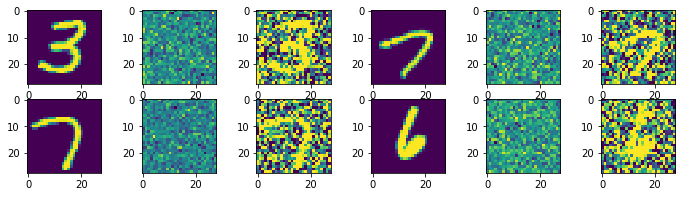

In [3]:
plt.figure(figsize=(12,3));j=1
for i in np.random.randint(0,len(x_train),4):
    plt.subplot(2,6,j);j+=1
    plt.imshow(x_train[i].reshape(28,28))
    plt.subplot(2,6,j);j+=1
    plt.imshow(noise[i].reshape(28,28))
    plt.subplot(2,6,j);j+=1
    plt.imshow(x_train_noisy[i].reshape(28,28))

In [0]:
#similarly prepare test data
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test = x_test.astype('float32') / 255
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128

### Encoder

In [6]:
# Build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
layer1_enc = Conv2D(filters=32,kernel_size=3,strides=2,activation='relu',padding='same')(inputs)
layer2_enc = Conv2D(filters=64,kernel_size=3,strides=2,activation='relu',padding='same')(layer1_enc)

# Shape info needed to build Decoder Model
shape = K.int_shape(layer2_enc)

x = Flatten()(layer2_enc)
latent = Dense(16,name='latent_vector')(x)
encoder = Model(inputs,latent,name='encoder')
encoder.summary()




Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [7]:
# Build the Decoder Model
latent_inputs = Input(shape=(16,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape(shape[1:])(x)

x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same')(x)

x = Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)
outputs = Activation('sigmoid', name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

### AutoEncoder

In [8]:
# Autoencoder = Encoder + Decoder
autoencoder = Model(inputs, decoder( encoder(inputs) ), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


### Compile and Train

In [9]:
autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)





Train on 60000 samples, validate on 10000 samples
Epoch 1/30





60000/60000 [==============================] - 17s 288us/step - loss: 0.0614 - val_loss: 0.0327
Epoch 2/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0263 - val_loss: 0.0225
Epoch 3/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0215 - val_loss: 0.0201
Epoch 4/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0195 - val_loss: 0.0187
Epoch 5/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0184 - val_loss: 0.0181
Epoch 6/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0177 - val_loss: 0.0175
Epoch 7/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.0172 - val_loss: 0.0171
Epoch 8/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0168 - val_loss: 0.0169
Epoch 9/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0164 - val

### See the results

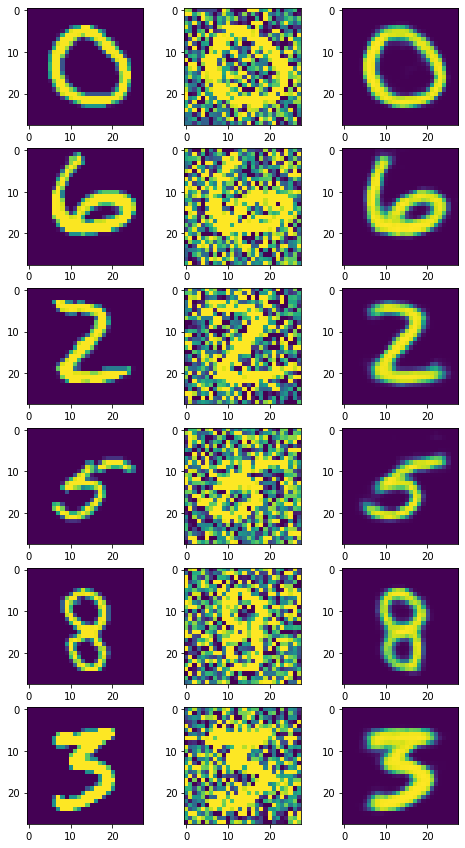

In [10]:
randoms = np.random.randint(0,len(x_test),size=6)
tests = x_test[randoms]
noisy_tests = x_test_noisy[randoms]
decoded_tests = x_decoded[randoms]

plt.figure(figsize=(8,15));j=1
for i in range(6):
    plt.subplot(6,3,j);j+=1
    plt.imshow(tests[i].reshape(28,28))
    plt.subplot(6,3,j);j+=1
    plt.imshow(noisy_tests[i].reshape(28,28))
    plt.subplot(6,3,j);j+=1
    plt.imshow(decoded_tests[i].reshape(28,28))